# Bocconi - Interview_call n°67342

Code to be present during the interview to partially answer the questions sent by e-mail.

In [1]:
# Change the cache folder for huggingface, since my hard disk C is full
import os
os.environ['HF_HOME'] = 'D:/Downloads/GIT/RETSURVEY_PROT/huggingface/cache'
print(os.environ.get('HF_HOME'))

D:/Downloads/GIT/RETSURVEY_PROT/huggingface/cache


In [2]:
# Import some libraries
import random
from transformers import pipeline, set_seed, GPT2LMHeadModel, GPT2Tokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# Instantiate the model and tokenizer with cache_dir argument
model = GPT2LMHeadModel.from_pretrained('gpt2', cache_dir='D:/Downloads/GIT/RETSURVEY_PROT/huggingface/cache')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', cache_dir='D:/Downloads/GIT/RETSURVEY_PROT/huggingface/cache')



## US Distribution Survey Generation

This code generates a synthetic survey dataset respecting the US distribution for political affiliation, income, age, and education. The goal of the survey is to understand people's thoughts on the retirement age and their reasons for retiring before the age of 65.

The code first defines the possible values for each feature, such as the reasons why people retire before the age of 65, age groups, education levels, income groups, and political affiliations, with their respective percentages.

Then, the code generates 15,000 examples by randomly selecting a reason ID from the defined list of reasons and generating a response to the question asked for the reason. The age group, gender, education level, income level, whether someone works in an intensive occupation, political affiliation, and support for postponing retirement are also randomly chosen according to their respective percentages.

The generated examples are stored in a list and saved as a CSV file every 50 iterations. This code can be useful for generating synthetic data for surveys and testing models or algorithms that analyze survey data.

In [ ]:
# Define possible values for each feature

# Define possible reasons why people retire before the age of 65 and the question to ask about them.
reasons = ["Laziness","Health problems","Financial concerns","Job Dissatisfaction","Family Responsibilities"]
question = "What do you think is the most common reason why people retire before the age of 65?"

# Define possible age groups and their respective percentages.
#['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 or older']
age_groups = [0, 1, 2, 3, 4, 5, 6, 7]
age_percents = [22.3, 9.4, 14.3, 15.4, 15.4, 12.7, 7.4, 3.1]

# Define possible education levels and their respective percentages.
# ['Less than a high school diploma', 'High school diploma or equivalent', 'Some college or associate's degree', 'Bachelor's degree or higher']
edu_groups = [0, 1, 2, 3]
edu_percents = [12.5, 27.6, 29.3, 30.6]

# Define possible income groups and their respective percentiles.
# ['$1 to $9,999', '$10,000 to $24,999', '$25,000 to $49,999', '$50,000 to $74,999', '$75,000 to $99,999', '$100,000 to $149,999', '$150,000 to $199,999', '$200,000 or more']
income_groups = [0, 1, 2, 3, 4, 5, 6, 7]
income_percentiles = [10.8, 17.5, 22.7, 18.9, 12.2, 11.5, 4.0, 2.4]

# Define possible political affiliations and their respective percentages.
#['Democrat', 'Republican', 'Independent']
pol_groups = [0, 1, 2]
pol_percents = [33, 29, 38]

# Generate 15,000 examples
examples = []
for i in range(15000):
    example = {}
    example["ID"] = i
    example['Reason_id'] = random.randint(0, 4) # Choose a random reason ID
    example["Reason"] = reasons[example['Reason_id'] ] # Use the corresponding reason for the ID
    set_seed(i)
    # Generate a response to the question asked for the reason.
    prompt = question + ' ' + example["Reason"] + '.'
    Text = tokenizer.decode(model.generate(
                                                tokenizer.encode(prompt, return_tensors='pt'), do_sample=True,
                                                max_length=50, num_beams=2, no_repeat_ngram_size=2, early_stopping=True,
                                                num_return_sequences=1)[0],skip_special_tokens=True)
    example["Text"] = Text[len(prompt):].replace('\n','') # Get just the answer
    example["Age"] = random.choices(age_groups, weights=age_percents)[0] # Choose a age group respecting percentiles
    example["Gender"] = random.randint(0, 1) # Choose a random gender
    example["Education"] = random.choices(edu_groups, weights=edu_percents)[0] # Choose a education level respecting percentiles
    example["Income"] = random.choices(income_groups, weights=income_percentiles)[0] # Choose a income level respecting percentiles
    example["Physically_occupation"] = random.randint(0, 1) # Choose a random binary to represent if someone work in a intensive occupation
    example["Political_affiliation"] = random.choices(pol_groups, weights=pol_percents)[0] # Choose political affiliation respecting percentiles
    example["Support"] = random.randint(0, 1) # Choose randomly if someone supports postponing retirement
    examples.append(example)
    if i % 50 == 0:
        example_df = pd.DataFrame(examples)
        example_df.to_csv('survey.csv',index=False)

Import the csv file in case we do not want to wait 9 hours to run the cell above. Also, creating a hot encoding for the column Reason.

In [3]:
example_df = pd.read_csv('survey.csv')

# create one-hot encoding for Reason column
reason_dummies = pd.get_dummies(example_df['Reason'])
example_df = pd.concat([example_df, reason_dummies], axis=1)

### Logistic Regression

We are performing a classic logistic regression. We expect no significant findings since all data was created randomly.

In [105]:
import statsmodels.api as sm

# define the independent variables
X = example_df[['Age', 'Gender', 'Education', 'Income', 'Physically_occupation',
                'Political_affiliation', 'Laziness' , 'Health problems',
                'Financial concerns', 'Job Dissatisfaction']]

# add intercept term
X = sm.add_constant(X)

# define the dependent variable
y = example_df['Support']

# fit the logistic regression model
model = sm.Logit(y, X).fit()

# print summary table of regression results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.692530
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                Support   No. Observations:                14951
Model:                          Logit   Df Residuals:                    14940
Method:                           MLE   Df Model:                           10
Date:                Wed, 10 May 2023   Pseudo R-squ.:               0.0007601
Time:                        00:21:23   Log-Likelihood:                -10354.
converged:                       True   LL-Null:                       -10362.
Covariance Type:            nonrobust   LLR p-value:                    0.1069
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0580      0.065      0.898      0.369      -0.069       0.

### Come up with a stochastic formula for supporting

The code applies a stochastic formula using a softmax function to determine whether someone supports postponing retirement based on their age, gender, education, income, physically occupation, political affiliation, and the reason they retire early.

Here\'s how the formula works:

$\text{logit}(Y)=\beta_{0}+\beta_{1}Age+\beta_{2}Gender+\beta_{3}Education+\beta_{4}Income+\beta_{5}Physically\_occupation+\beta_{6}Political\_affiliation+\beta_{7}Laziness+\beta_{8}Health\_problems+\beta_{9}Financial\_concerns+\beta_{10}Family\_Responsibilities+\epsilon$

where $\text{logit}(Y)$ is the log odds of the dependent variable $Y$, $\beta_0$ is the intercept (account for Job Dissatisfaction), and $\beta_1$ through $\beta_{10}$ are the coefficients for each of the independent variables Age, Gender, Education, Income, Physically Occupation, Political Affiliation, Laziness, Health problems, Financial concerns, Job Dissatisfaction, and Family Responsibilities, respectively. The error term is denoted by $\epsilon$.

In [112]:
# Define coefficients for each feature's effect on support
age_coeff = 0.1 #beta1
gender_coeff = 0.1 #beta2
edu_coeff = 0.1 #beta3
income_coeff = 0.05 #beta4
occupation_coeff = 0.2 #beta5
pol_coeff = 0.2 #beta6
reason_coeff_laziness = 0.3 #beta7
reason_coeff_health = -0.5 #beta8
reason_coeff_financial = 0.5 #beta9
reason_coeff_family = 0.3 #beta10

# Define intercept and noise
intercept = -0.6 #beta0
noise = np.random.normal(0,0.4,size=len(example_df)) #error


# Generate dependent variable Y in a logit way
logit = (age_coeff * example_df['Age'].values +
         gender_coeff * example_df['Gender'].values +
         edu_coeff * example_df['Education'].values +
         income_coeff * example_df['Income'].values +
         occupation_coeff * example_df['Physically_occupation'].values +
         pol_coeff * example_df['Political_affiliation'].values +
         reason_coeff_laziness * example_df['Laziness'].values +
         reason_coeff_health * example_df['Health problems'].values +
         reason_coeff_financial * example_df['Financial concerns'].values +
         reason_coeff_family * example_df['Family Responsibilities'].values +
         intercept + noise
            )

example_df['logit'] = logit
example_df['Support_2'] = np.random.binomial(n=1, p=np.exp(logit)/(1+np.exp(logit)))

Applying the logistic regression on the calculated dependent variable

In [113]:
import statsmodels.api as sm

# define the independent variables
X = example_df[['Age', 'Gender', 'Education', 'Income', 'Physically_occupation',
                'Political_affiliation', 'Laziness' , 'Health problems',
                'Financial concerns', 'Family Responsibilities']]

# add intercept term
X = sm.add_constant(X, prepend = False)

# define the dependent variable
y = example_df['Support_2'].values

# fit the logistic regression model
model = sm.Logit(y, X).fit()

# print summary table of regression results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.646921
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                14951
Model:                          Logit   Df Residuals:                    14940
Method:                           MLE   Df Model:                           10
Date:                Wed, 10 May 2023   Pseudo R-squ.:                 0.03498
Time:                        00:24:42   Log-Likelihood:                -9672.1
converged:                       True   LL-Null:                       -10023.
Covariance Type:            nonrobust   LLR p-value:                3.600e-144
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Age                         0.0987      0.008     11.812      0.000       0.082   

## Sentiment Analyses

Sentiment analysis can be used to identify the emotional tone of responses to open-ended questions in a survey. This information can be used to understand better the respondents' underlying attitudes and emotions toward the topic being surveyed and to identify any trends or patterns in the data.

We are using the Transformers library to apply sentiment analysis to each row in the dataset. The pipeline function allows you to easily initialize a pre-trained sentiment analysis model and apply it to the text data. The sentiment variable stores the sentiment label (positive or negative) for each text in the dataset. The resulting sentiment labels are added to the example_df dataset as a new column called 'Sentiment'. In cases where there is no text, I update with 'no_text'.

In [10]:
from transformers import pipeline
from tqdm import tqdm

# Initialize the sentiment analysis pipeline
sentiment_classifier = pipeline('sentiment-analysis')

# Apply sentiment analysis to each row in the dataset
sentiments = []
for text in tqdm(example_df['Text']):
    try:
        sentiment = sentiment_classifier(text)[0]
        sentiments.append(sentiment['label'])
    except:
        sentiments.append('No_text')

# Add the 'Sentiment' column to the dataset
example_df['Sentiment'] = sentiments

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
100%|██████████| 14951/14951 [13:29<00:00, 18.48it/s]


Some examples to test the pretrained model

In [119]:
# Examples of the pretrained model with different examples 
example_positive = "I think the most common reason people retire before 65 is because they have worked hard their entire\n \
     lives and are financially secure enough to enjoy their retirement. It's great to see people enjoying the fruits of their labor!"
print(f"Input:{example_positive}")
print(f"Result:{sentiment_classifier(example_positive)}")
print()
example_negative =  "The sad reality is that many people are forced to retire before 65 because they have health issues \n \
     that prevent them from working. It's a terrible situation that nobody wants to be in."
print(f"Input:{example_negative}")
print(f"Result:{sentiment_classifier(example_negative)}")
print()

Input:I think the most common reason people retire before 65 is because they have worked hard their entire
      lives and are financially secure enough to enjoy their retirement. It's great to see people enjoying the fruits of their labor!
Result:[{'label': 'POSITIVE', 'score': 0.9998419284820557}]

Input:The sad reality is that many people are forced to retire before 65 because they have health issues 
      that prevent them from working. It's a terrible situation that nobody wants to be in.
Result:[{'label': 'NEGATIVE', 'score': 0.9989998936653137}]



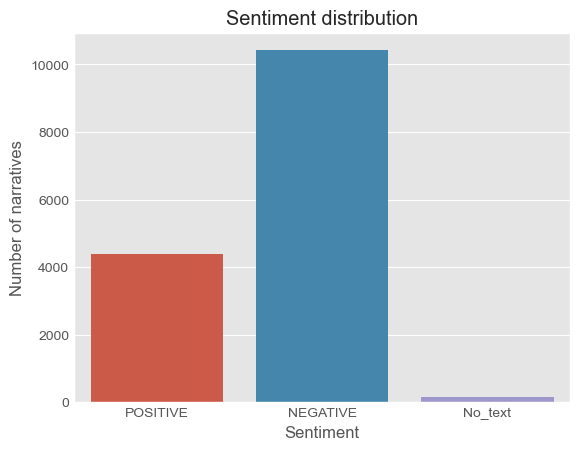

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Create a bar plot of the number of narratives for each sentiment
sns.countplot(x='Sentiment', data=example_df)
plt.title('Sentiment distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of narratives')
plt.show()

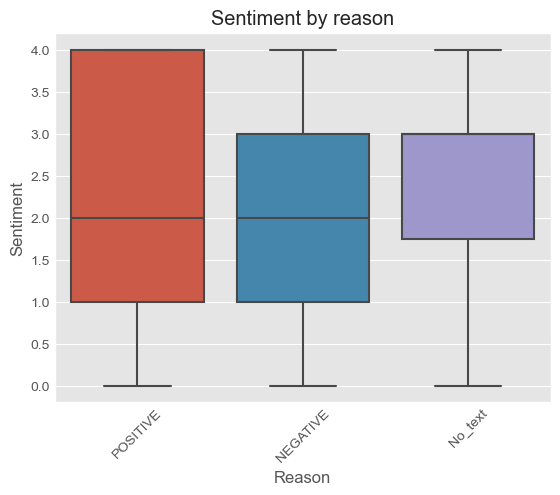

In [28]:
# Create a box plot of the sentiment by reason
sns.boxplot(x='Sentiment', y='Reason_id', data=example_df)
plt.title('Sentiment by reason')
plt.xlabel('Reason')
plt.ylabel('Sentiment')
plt.xticks(rotation=45)
plt.show()

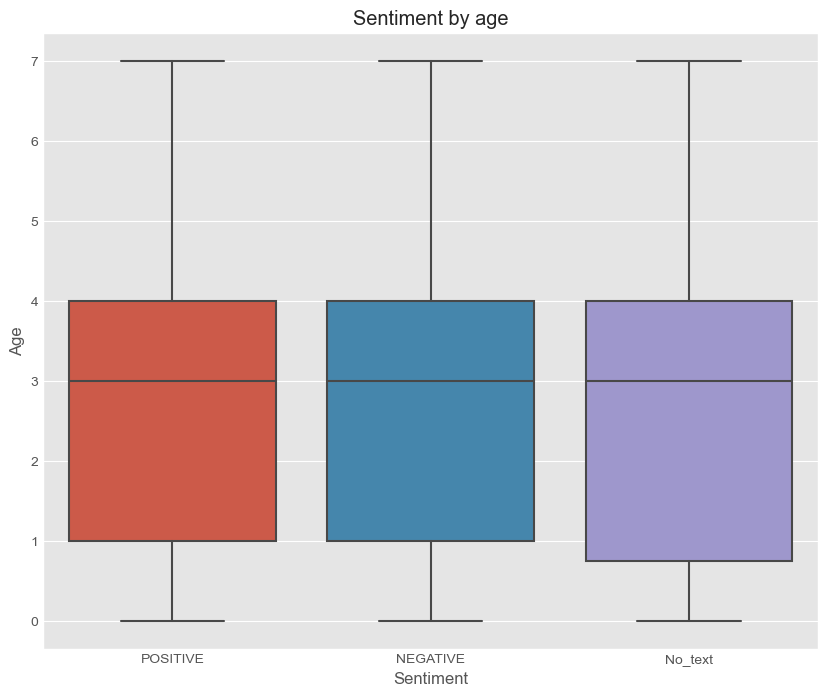

In [104]:
# Create a box plot of the sentiment by age
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.boxplot(x='Sentiment', y='Age', data=example_df)
ax.set_title('Sentiment by age')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Age')
plt.show()

d:\Downloads\GIT\RETSURVEY_PROT\myenv\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
d:\Downloads\GIT\RETSURVEY_PROT\myenv\Lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


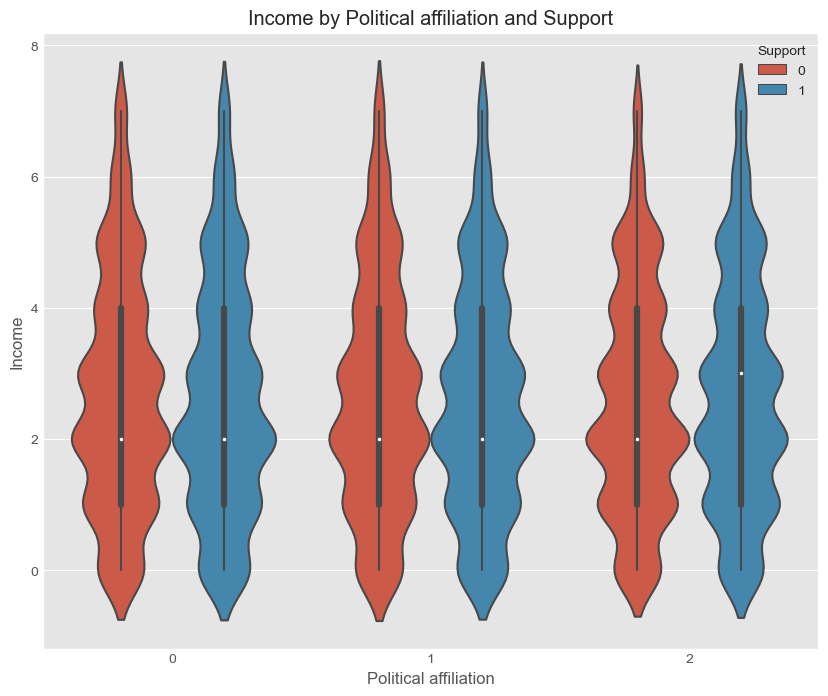

In [121]:
# Create a box plot of the sentiment by age
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.violinplot(data=example_df, x="Political_affiliation", y="Income", hue="Support")
ax.set_title('Income by Political affiliation and Support')
ax.set_xlabel('Political affiliation')
ax.set_ylabel('Income')
plt.show()

## Text Investigation

To investigate the most important words for each type of reason in our dataset, we can use a text analysis approach. One common method is to use a bag-of-words model, which represents each document as a vector of word counts. Then, you can use dimensionality reduction techniques such PCA to visualize the high-dimensional vectors in 2D space.

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Define the corpus as the text column
corpus = example_df['Text'].fillna('no_text')

# Define the vectorizer to convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english', strip_accents='unicode')

# Create the TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(corpus)


# Get the top 10 words for each reason
reasons = ["Laziness","Health problems","Financial concerns","Job Dissatisfaction","Family Responsibilities"]
# loop through each reason and get the most common words
for reason in reasons:
    # get the examples for the current reason
    reason_examples = example_df[example_df[reason]==1]
    
    # get the text for the reason examples
    reason_text = reason_examples['Text'].fillna('no_text').values
    
    # compute the TF-IDF weights
    weights = tfidf_matrix[reason_examples.index].sum(axis=0).A1
    # get the feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # get the word weights as an array
    word_weights = dict(zip(feature_names, weights))
    
    # sort the words by weight in descending order
    sorted_words = sorted(word_weights.items(), key=lambda x: x[1], reverse=True)
    
    # get the top 10 most important words
    top_words = [word for word, weight in sorted_words[:10]]
    
    # print the top words for the reason
    print(reason + ': ' + str(top_words))


Laziness: ['laziness', 'people', 'think', 'don', 'retire', 'early', 'problem', 'lot', 'retirement', 'reasons']
Health problems: ['health', 'think', 'problems', 'people', 'retire', 'don', 'know', 'lot', '65', 'retirement']
Financial concerns: ['think', 'retirement', 'people', 'lot', 'financial', 'retire', 'don', 'early', 'reasons', 'going']
Job Dissatisfaction: ['job', 'people', 'think', 'retire', 'don', 'reasons', 'want', 'question', 'work', 'early']
Family Responsibilities: ['family', 'responsibilities', 'retirement', 'retire', 'reasons', 'early', 'people', 'children', '65', 'following']


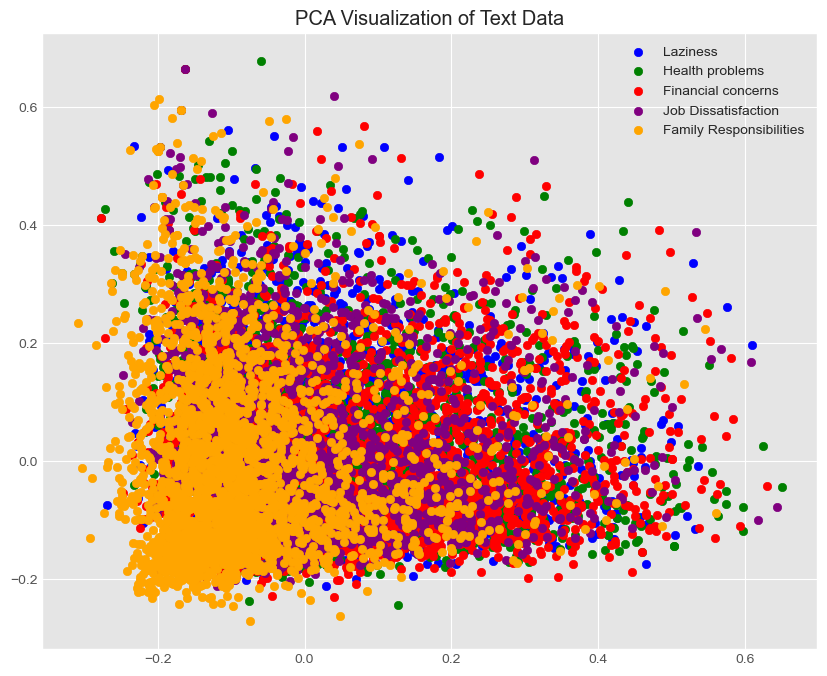

In [97]:
# Define the PCA and TSE models
pca = PCA(n_components=2)

# Define the colors for each reason
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Define the labels as the reason column
labels = example_df['Reason']

# Fit and transform the bag-of-words matrix with the PCA model
pca_matrix = pca.fit_transform(tfidf_matrix.toarray())

# Plot the PCA results
plt.figure(figsize=(10, 8))
for i, reason in enumerate(reasons):
    plt.scatter(pca_matrix[labels == reason, 0], pca_matrix[labels == reason, 1], c=colors[i], label=reason)
plt.legend()
plt.title('PCA Visualization of Text Data')
plt.show()

## Topic Modeling

Latent Dirichlet Allocation (LDA) is a probabilistic topic modeling technique that assigns a range of topics to a collection of documents based on the occurrence of words in the corpus. LDA assumes that each document is a mixture of several topics, where each topic is a probability distribution over words. The main goal of the LDA model is to learn the topic distributions for each document and the word distributions for each topic.

LDA is used for topic modeling because it is a powerful and flexible technique for analyzing large data. It can identify underlying themes and patterns in the data, and can be used for tasks such as text classification, information retrieval, and recommendation systems.

When using LDA for topic modeling, it is important to be aware of the following:

* The number of topics to be extracted: This is a hyperparameter that needs to be specified before running the LDA model. The optimal number of topics depends on the data and the task, and can be determined using techniques such as grid search and cross-validation.

* The quality of the results: The quality of the topics extracted by LDA depends on the quality of the input data, the size of the corpus, and the choice of hyperparameters. It is important to evaluate the results of the LDA model to ensure that the topics make sense and are relevant to the task at hand.

* The interpretability of the topics: LDA generates a set of topics, each represented by a distribution over words. It is important to ensure that the topics are interpretable and meaningful, and that they can be used to gain insights into the data.

We used TF-IDF vectorization to represent the documents as vectors, and then fitting an LDA model to the vectors to extract the topics. We tehn print the top 10 words for each topic, which is a common way to interpret and evaluate the results of the LDA model. To select the number of topics, we set it to 5. However, it is important to note that the optimal number of topics may vary depending on the data and the task.

In [98]:
from sklearn.decomposition import LatentDirichletAllocation

# Define the number of topics to be extracted
num_topics = 5

# Define the LDA model with the specified number of topics
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Fit the LDA model to the bag-of-words matrix
lda_model.fit(tfidf_matrix)

# Print the top 10 words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))
    print()

Topic #0:
think don question know things lot sure answer retirement ve

Topic #1:
family responsibilities average age no_text 65 retirement years children spouse

Topic #2:
laziness people problem factors retirement job lack number cause major

Topic #3:
people retire think don early lot likely health reasons want

Topic #4:
reasons retirement following early retire common retiring people looking thoughts



## Word Embbedings - Word2Vec

Word vectors are multi-dimensional representations of words in a vector space, where each dimension corresponds to a feature of the word. They can be used to capture semantic relationships between words and are used in various natural language processing (NLP) tasks like sentiment analysis, text classification, and information retrieval.

Word2Vec is a popular algorithm for generating word vectors that represent words as dense, low-dimensional vectors in a continuous vector space. It is a neural network-based approach that learns the vector representations of words from a large corpus of text. The basic idea behind Word2Vec is that words that appear in similar contexts have similar meanings.

Great notebook explanation: https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469

Word2Vec paper: https://arxiv.org/abs/1301.3781

In [148]:
# Import the required libraries
from gensim.models import Word2Vec
import nltk

# Text example 
# Define a list of sentences to train the model on
sentences = [["King", "Man"], ["Queen", "Woman"], ["Man", "Woman"], 
             ["King", "Queen"], ["Apple", "King"], ["Apple", "Man"], ["Apple", "Queen"], ["Apple", "Woman"]]

# Train the Word2Vec model on the sentences
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Find the most similar words to "King - Man + Woman"
similar_words = model.wv.most_similar(positive=['King', 'Man'], negative=['Woman'],topn=3)

# Print the result
print(similar_words)

[('Queen', 0.10844126343727112), ('Apple', -0.07731582969427109)]


In [132]:
texts = example_df['Text'].fillna('no_Text').apply(lambda x: str(x)).values

# Tokenize the sentences
tokenized_sentences = [nltk.word_tokenize(text) for text in texts]

# Train the Word2Vec model on the tokenized sentences
model = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

In [139]:
# Find the most similar words to 'laziness'
similar_words = model.wv.most_similar('laziness', topn=5)

# Print the result
print( "Words Close to laziness")
for w in similar_words:
    print(w)
print()

# Find the most similar words to "King - Man + Woman"
similar_words = model.wv.most_similar(positive=['laziness', 'health'], negative=['financial'], topn=5)

print( "Words Close to laziness + health - financial")
for w in similar_words:
    print(w)

Words Close to laziness
('aging', 0.7747504711151123)
('stress', 0.7376060485839844)
('mystery', 0.7231273055076599)
('physical', 0.7228684425354004)
('process', 0.6836643815040588)

Words Close to laziness + health - financial
('aging', 0.6716219782829285)
('illness', 0.6488679647445679)
('physical', 0.625668466091156)
('motivation', 0.623317539691925)
('self-control', 0.6221350431442261)
